1. [Setup data set](#qH6NSvLcvWq0dIOGUFm7hjIWOO9EcDo4yg)
2. [Define Mine model](#LWu8a55iXd1rXiOxqHLRRPEri06W2uHUSaopejkOyLc)
3. First architecture
    1. [Compute MI of fine-grained model with Net 1](#ITDw/rAcOpXEcj2/jr66qiHnAVLmZUerYxogQhfGZKU)
        1. [Compute MI of fine-grained model with Net 1 (learning rate experiment)](#rsXTn4Xt28E5GogIizo92r/Pd6a2FFGwwk7KSKGENeY)
    2. [Compute MI of frozen convolution with Net 1](#XwBXAc9EQHz4UXGAypEpu8Nx1VSK7MgK6aV54)
4. [Alternative architecture](#bmPi9gykQdCvsmB9Ey9o3N0Z2tpRuAEEgPXrIqeLp5M8)
    1. [Compute MI of fine-grained 3x3 model with Net 2](#XMXqmJFyTasMbsY1APB9UEA)
        1. [Compute MI of fine-grained 3x3 model with Net 2 (learning rate scheduler experiment)](#ks6iDaSVrGnNdtAaveXITBiwGVqpS4aom7JFAik9UsY)
    2. [Compute MI of frozen 3x3 convolution with Net 2](#StnSWBsZkvH19fVkpidI)
        1. [Compute MI of frozen 3x3 convolution with Net 2 (learning rate scheduler experiment)](#75w0xiOCI1V0afZ12xKy4NqY)
        2. [Compute MI of frozen 3x3 convolution with Net 2 (learning rate)](#yjaFT5zBKGsxifupr2J1qLx8w)
    3. [Mine on the fine-grained data (on the 2x2 model)](#zu750PMa3YAxhw2z49AvlNJP1DE)
    4. [Mine on the coarse-grained frozen convolution (on the 2x2 model)](#FxFiXG4HyPIyOgPFs3aNTLDoI)
    5. [Jointly optimize the coarse-grained convolution (on the 2x2 model) and MI of coarse-grained convolution](#gS7O2ggXcb34OJzzvfm2crOhmEGCROW)
5. [Analytic MI frozen convolution](#IMXNuzYpbqF3yE71tcGPkyCUgonu44gg0wtJKI)
    1. [Analytic fine-grained MI calculation](#W6fWYl5TZGWfK9Zt8dXCH65nSc5Uk)
    2. [Analytic MI frozen convolution](#i4EUlSNUCLAqQFRTDCFVrpJ)









# Setup dataset
<a id='qH6NSvLcvWq0dIOGUFm7hjIWOO9EcDo4yg'></a>

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
# from mine.models.mine import Mine
dat = np.load("ising27x27from2187x2187.npy")
class Net(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(Net, self).__init__()
        self.x_fc1 = nn.Linear(x_dim, H)
        self.x_fc3 = nn.Linear(H, H)
        
        self.y_fc1 = nn.Linear(y_dim, H)
        self.y_fc3 = nn.Linear(H, H)
        
        self.fc3 = nn.Linear(H, H // 4)
        self.fc4 = nn.Linear(H // 4, 1)
        
        
    def forward(self, x, y):
        inter_x = F.relu(self.x_fc1(x))
        inter_x = F.relu(self.x_fc3(inter_x))
        
        inter_y = F.relu(self.y_fc1(y))
        inter_y = F.relu(self.y_fc3(inter_y))
        
        
        h2 = F.relu(self.fc3(inter_x + inter_y))
        h2 = (self.fc4(h2))
        return h2    


In [2]:
Xlist = []
Ylist = []
for _ in range(10000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 3)
    j = np.random.randint(dat.shape[1] - 6)
#     if _ < 20:
#         print(dat[num, i:(i+3), j:(j+6)])
    Xlist.append(dat[num, i:(i+3), j:(j+3)])
    Ylist.append(dat[num, i:(i+3), (j+3):(j+6)])

X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)

In [3]:

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)



# Define Mine model
<a id='LWu8a55iXd1rXiOxqHLRRPEri06W2uHUSaopejkOyLc'></a>

In [4]:
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss
class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, train_loader = None, schedule = None):
        
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float(), y.float())
                loss.backward()
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            iter_mi = 30
            if iter % (iter_mi) == 0:
                current_mi = self.mi(X, Y)
                print(f"It {iter} - Current MI: {current_mi} ")
        final_mi = self.mi(X, Y)
        print(f"Final MI: {final_mi}")
        return final_mi

mine = Mine(
    T = Net(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)



Device: cpu


### Compute MI of fine-grained model with Net 1
<a id='ITDw/rAcOpXEcj2/jr66qiHnAVLmZUerYxogQhfGZKU'></a>

In [6]:
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


It 3 - MI: 0.07008462189696729 
It 6 - MI: 0.07274418754968792 
It 9 - MI: 0.0729049873771146 
It 12 - MI: 0.07502256380394101 
It 15 - MI: 0.0744599507888779 
It 18 - MI: 0.07562138675712049 
It 21 - MI: 0.07709674560464919 
It 24 - MI: 0.07503052440006286 
It 27 - MI: 0.08123948227148503 
It 30 - MI: 0.07833210297394544 
It 33 - MI: 0.08167970005888492 
It 36 - MI: 0.08092826756183058 
It 39 - MI: 0.08341205306351185 
It 42 - MI: 0.08181722706649452 
It 45 - MI: 0.0822858614847064 
It 48 - MI: 0.08179314702283591 
It 51 - MI: 0.08143996493890882 
It 54 - MI: 0.0791773566743359 
It 57 - MI: 0.08071585884317756 
It 60 - MI: 0.08220519893802702 
It 63 - MI: 0.0830302886897698 
It 66 - MI: 0.0824671775335446 
It 69 - MI: 0.08390749280806631 
It 72 - MI: 0.08464319666381925 
It 75 - MI: 0.08326308615505695 
It 78 - MI: 0.08059568458702415 
It 81 - MI: 0.08502050093375146 
It 84 - MI: 0.08725323155522346 
It 87 - MI: 0.08555637754034251 
It 90 - MI: 0.08451901329681277 
It 93 - MI: 0.08510

In [5]:
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


It 3 - MI: 0.06671573655330576 
It 6 - MI: 0.07242919114651158 
It 9 - MI: 0.0761397413443774 
It 12 - MI: 0.0771521259448491 
It 15 - MI: 0.07531956513412297 
It 18 - MI: 0.07465406856499612 
It 21 - MI: 0.0765228207455948 
It 24 - MI: 0.07656780182151124 
It 27 - MI: 0.07735614327248186 
It 30 - MI: 0.07824272965081036 
It 30 - Current MI: 0.4942653477191925 
It 33 - MI: 0.07898901612497866 
It 36 - MI: 0.07590022345539182 
It 39 - MI: 0.0778564423089847 
It 42 - MI: 0.07997763756429777 
It 45 - MI: 0.0803540509659797 
It 48 - MI: 0.0818093471461907 
It 51 - MI: 0.08089141186792403 
It 54 - MI: 0.08469704771414399 
It 57 - MI: 0.08168612467125058 
It 60 - MI: 0.082245466648601 
It 60 - Current MI: 0.528404712677002 
It 63 - MI: 0.07992291485425085 
It 66 - MI: 0.08381677069701254 
It 69 - MI: 0.08605594607070088 
It 72 - MI: 0.082442611688748 
It 75 - MI: 0.08269600686617196 
It 78 - MI: 0.08164517511613667 
It 81 - MI: 0.08422639209311455 
It 84 - MI: 0.08647373225539923 
It 87 - MI

#### Compute MI of fine-grained model with Net 1 (learning rate experiment)
<a id='rsXTn4Xt28E5GogIizo92r/Pd6a2FFGwwk7KSKGENeY'></a>

In [19]:
mine = Mine(
    T = Net(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.0001)


It 3 - MI: 0.006768424136680551 
It 6 - MI: 0.02744475210784003 
It 9 - MI: 0.05619841243606061 
It 12 - MI: 0.06545146892312914 
It 15 - MI: 0.0696914658183232 
It 18 - MI: 0.06996388814877719 
It 21 - MI: 0.07104836648795754 
It 24 - MI: 0.07315817882772535 
It 27 - MI: 0.07402952562551945 
It 30 - MI: 0.0721593740163371 
It 30 - Current MI: 0.4698069393634796 
It 33 - MI: 0.07608817145228386 
It 36 - MI: 0.07188724947627634 
It 39 - MI: 0.07396237622015178 
It 42 - MI: 0.07628489169292152 
It 45 - MI: 0.07695151143707335 
It 48 - MI: 0.07739648048300296 
It 51 - MI: 0.07551427942235023 
It 54 - MI: 0.07507580635137856 
It 57 - MI: 0.07725312258116901 
It 60 - MI: 0.07819430576637387 
It 60 - Current MI: 0.5047367215156555 
It 63 - MI: 0.07463157863821834 
It 66 - MI: 0.07602576084900647 
It 69 - MI: 0.07576111552771181 
It 72 - MI: 0.07690770004410297 
It 75 - MI: 0.07771772833075374 
It 78 - MI: 0.07777086470741779 
It 81 - MI: 0.07790419564116746 
It 84 - MI: 0.07938557863235474 


### Compute MI of frozen convolution with Net 1
<a id='XwBXAc9EQHz4UXGAypEpu8Nx1VSK7MgK6aV54'></a>

In [9]:
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

In [10]:
mine = Mine(
    T = Net(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)

train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


It 3 - MI: 0.06134333892259747 
It 6 - MI: 0.06352697580587119 
It 9 - MI: 0.06262765120482072 
It 12 - MI: 0.06320377695374191 
It 15 - MI: 0.06307923537679017 
It 18 - MI: 0.0654634591192007 
It 21 - MI: 0.06463840208016336 
It 24 - MI: 0.06206720392219722 
It 27 - MI: 0.06437410786747932 
It 30 - MI: 0.0627430472522974 
It 30 - Current MI: 0.39625075459480286 
It 33 - MI: 0.06504406651947647 
It 36 - MI: 0.06328759284224361 
It 39 - MI: 0.06451983051374555 
It 42 - MI: 0.06340134562924504 
It 45 - MI: 0.06923823314718902 
It 48 - MI: 0.06378193967975676 
It 51 - MI: 0.0627216735156253 
It 54 - MI: 0.06236998876556754 
It 57 - MI: 0.06489942129701376 
It 60 - MI: 0.06447073922026902 
It 60 - Current MI: 0.4103621244430542 
It 63 - MI: 0.06288437778130174 
It 66 - MI: 0.06235055427532643 
It 69 - MI: 0.06403500586748123 
It 72 - MI: 0.06514549697749317 
It 75 - MI: 0.06486529461108148 
It 78 - MI: 0.061533990083262324 
It 81 - MI: 0.06264891376486048 
It 84 - MI: 0.06343726092018187 


In [ ]:
mine = Mine(
    T = Net(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


## Alternative architecture
<a id='bmPi9gykQdCvsmB9Ey9o3N0Z2tpRuAEEgPXrIqeLp5M8'></a>

In [13]:
class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

### Compute MI of fine-grained 3x3 model with Net 2
<a id='XMXqmJFyTasMbsY1APB9UEA'></a>

In [20]:
mine = Mine(
    T = AltNet(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001)


It 3 - MI: 0.07986841315869242 
It 6 - MI: 0.08012104372028261 
It 9 - MI: 0.08389029931277037 
It 12 - MI: 0.08021288667805493 
It 15 - MI: 0.08340090839192271 
It 18 - MI: 0.0850527964066714 
It 21 - MI: 0.08062627364415675 
It 24 - MI: 0.08316428458783776 
It 27 - MI: 0.08517029590439051 
It 30 - MI: 0.08587313489988446 
It 30 - Current MI: 0.5478309988975525 
It 33 - MI: 0.08383182703983039 
It 36 - MI: 0.08851679088547826 
It 39 - MI: 0.08907535357866436 
It 42 - MI: 0.08598342502955347 
It 45 - MI: 0.08646479237359017 
It 48 - MI: 0.08652423252351582 
It 51 - MI: 0.08669775258749723 
It 54 - MI: 0.08645893284119666 
It 57 - MI: 0.08997832785826176 
It 60 - MI: 0.08846540050581098 
It 60 - Current MI: 0.5680541396141052 
It 63 - MI: 0.09084817115217447 
It 66 - MI: 0.08755044464487582 
It 69 - MI: 0.0902691618539393 
It 72 - MI: 0.08913269371259958 
It 75 - MI: 0.08955364243593067 
It 78 - MI: 0.09253881790209562 
It 81 - MI: 0.09201977960765362 
It 84 - MI: 0.09454076900146902 
I

#### Compute MI of fine-grained 3x3 model with Net 2 (learning rate scheduler experiment)
<a id='ks6iDaSVrGnNdtAaveXITBiwGVqpS4aom7JFAik9UsY'></a>

In [26]:
mine = Mine(
    T = AltNet(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


It 3 - MI: 0.07365029340144247 
It 6 - MI: 0.08082374348305166 
It 9 - MI: 0.08032285619992763 
It 12 - MI: 0.08507946855388582 
It 15 - MI: 0.08582785108592361 
It 18 - MI: 0.08345578389707953 
It 21 - MI: 0.08562803466338664 
It 24 - MI: 0.0851346239214763 
It 27 - MI: 0.08490697923116386 
It 30 - MI: 0.08509183372370899 
It 30 - Current MI: 0.5405021905899048 
It 33 - MI: 0.08640795957762748 
It 36 - MI: 0.0870345865841955 
It 39 - MI: 0.08511458348948509 
It 42 - MI: 0.0899708135984838 
It 45 - MI: 0.08873679919634014 
It 48 - MI: 0.08706821617670357 
It 51 - MI: 0.08644251234363765 
It 54 - MI: 0.08875817840453237 
It 57 - MI: 0.08996147499419749 
It 60 - MI: 0.09070484596304595 
It 60 - Current MI: 0.5662187933921814 
It 63 - MI: 0.08748656196985394 
It 66 - MI: 0.0867386213503778 
It 69 - MI: 0.09257657267153263 
It 72 - MI: 0.09479842183645815 
It 75 - MI: 0.09170476952567697 
It 78 - MI: 0.09249614353757352 
It 81 - MI: 0.09085494617465883 
It 84 - MI: 0.0939251366071403 
It 8

### Compute MI of frozen convolution with Net 2
<a id='StnSWBsZkvH19fVkpidI'></a>

In [16]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)



It 3 - MI: 0.06343564949929714 
It 6 - MI: 0.06683945981785655 
It 9 - MI: 0.0639899632660672 
It 12 - MI: 0.06402968824841082 
It 15 - MI: 0.06490643532015383 
It 18 - MI: 0.06637493532616645 
It 21 - MI: 0.06651480356231332 
It 24 - MI: 0.06310932477936149 
It 27 - MI: 0.06371388328261673 
It 30 - MI: 0.06242774403654039 
It 30 - Current MI: 0.4098704755306244 
It 33 - MI: 0.06284661998506635 
It 36 - MI: 0.06569516577292234 
It 39 - MI: 0.06464470125501975 
It 42 - MI: 0.06556490727234632 
It 45 - MI: 0.06508606788702309 
It 48 - MI: 0.06370523280929774 
It 51 - MI: 0.06565290945582092 
It 54 - MI: 0.06531997583806515 
It 57 - MI: 0.06510274368338287 
It 60 - MI: 0.06309182406403124 
It 60 - Current MI: 0.41787514090538025 
It 63 - MI: 0.06584612838923931 
It 66 - MI: 0.06436976994154975 
It 69 - MI: 0.06679132406134158 
It 72 - MI: 0.06543238833546638 
It 75 - MI: 0.0665474453708157 
It 78 - MI: 0.0632512237643823 
It 81 - MI: 0.06187510001473129 
It 84 - MI: 0.06794505822472274 
I

#### Compute MI of frozen convolution with Net 2 (learning rate scheduler experiment)
<a id='75w0xiOCI1V0afZ12xKy4NqY'></a>

In [27]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


It 3 - MI: 0.06144055840559304 
It 6 - MI: 0.06584827124606818 
It 9 - MI: 0.06539601716212928 
It 12 - MI: 0.06455067940987647 
It 15 - MI: 0.06497694941936061 
It 18 - MI: 0.0655875860247761 
It 21 - MI: 0.0644091556314379 
It 24 - MI: 0.06579643883742392 
It 27 - MI: 0.06369544146582484 
It 30 - MI: 0.06633805972523987 
It 30 - Current MI: 0.4100392460823059 
It 33 - MI: 0.06556023575831205 
It 36 - MI: 0.0666705738985911 
It 39 - MI: 0.06308042904129252 
It 42 - MI: 0.0670079697156325 
It 45 - MI: 0.06301511661149561 
It 48 - MI: 0.06534086773172021 
It 51 - MI: 0.06374110572505742 
It 54 - MI: 0.06625010084826499 
It 57 - MI: 0.06323706987313926 
It 60 - MI: 0.06332295550964773 
It 60 - Current MI: 0.42923012375831604 
It 63 - MI: 0.06344915193039924 
It 66 - MI: 0.06542760587763041 
It 69 - MI: 0.06302743987180293 
It 72 - MI: 0.06613539636600763 
It 75 - MI: 0.06507517432328314 
It 78 - MI: 0.06610446877311915 
It 81 - MI: 0.06403610424604267 
It 84 - MI: 0.06436998466961086 
It

#### Compute MI of frozen convolution with Net 2 (learning rate)
<a id='yjaFT5zBKGsxifupr2J1qLx8w'></a>

In [28]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.01, 
                   schedule = {'step_size': 30, 'gamma': 0.3})


It 3 - MI: 0.06474318011896685 
It 6 - MI: 0.0655315270414576 
It 9 - MI: 0.06170601851772517 
It 12 - MI: 0.06345860415603966 
It 15 - MI: 0.06423425965476781 
It 18 - MI: 0.064614886068739 
It 21 - MI: 0.06501619797199965 
It 24 - MI: 0.06612171704182401 
It 27 - MI: 0.06405461160466075 
It 30 - MI: 0.0653219287050888 
It 30 - Current MI: 0.41019779443740845 
It 33 - MI: 0.06300568801816553 
It 36 - MI: 0.06563587754499167 
It 39 - MI: 0.06271395302610472 
It 42 - MI: 0.06476206169463694 
It 45 - MI: 0.06406965223141015 
It 48 - MI: 0.06360208929982036 
It 51 - MI: 0.06462043337523937 
It 54 - MI: 0.06627429299987853 
It 57 - MI: 0.06425415247213095 
It 60 - MI: 0.06589269981486723 
It 60 - Current MI: 0.4200051724910736 
It 63 - MI: 0.06739952997304499 
It 66 - MI: 0.0646810190519318 
It 69 - MI: 0.06471341603901237 
It 72 - MI: 0.06418027129257098 
It 75 - MI: 0.06595755578018725 
It 78 - MI: 0.0647367846686393 
It 81 - MI: 0.06359718454768881 
It 84 - MI: 0.06518050376325846 
It 8

In [5]:
Xlist

[array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [1, 1, 0],
        [0, 0, 1]]), array([[0, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]), array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 1, 1]]), array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), array([[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1]]), array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), array([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]), array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), array([[1, 0, 0],
        [0, 0, 1],
        [0, 0, 0]]), array([[1, 0,

## Mine on the fine-grained data (on the 2x2 model)
<a id='zu750PMa3YAxhw2z49AvlNJP1DE'></a>

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss
class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, train_loader = None, schedule = None):
        
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])

        current_mi = None
        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float(), y.float())
                loss.backward(retain_graph=True)
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            iter_mi = 30
            if iter % (iter_mi) == 0:
                current_mi = self.mi(X, Y)
                print(f"It {iter} - Current MI: {current_mi} ")
#         final_mi = self.mi(X, Y)
#         print(f"Final MI: {final_mi}")
        return current_mi, opt

class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
# load 2x4 rectangles
dat = np.load("ising27x27from2187x2187.npy")
Xlist = []
Ylist = []
for _ in range(10000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 2)
    j = np.random.randint(dat.shape[1] - 4)
    Xlist.append(dat[num, i:(i+2), j:(j+2)])
    Ylist.append(dat[num, i:(i+2), (j+2):(j+4)])



Device: cpu


In [3]:
mine = Mine(
    T = AltNet(x_dim =  4, y_dim = 4),
    loss = 'mine' #mine_biased, fdiv
)

X = np.array(Xlist).astype(float).reshape(-1, 4)
Y = np.array(Ylist).astype(float).reshape(-1, 4)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 50, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


It 3 - MI: 0.06260132475290447 
It 6 - MI: 0.06391683930996805 
It 9 - MI: 0.06689506489783525 
It 12 - MI: 0.06436167634092271 
It 15 - MI: 0.06954176793806255 
It 18 - MI: 0.06499620887916535 
It 21 - MI: 0.06409116636496037 
It 24 - MI: 0.06666725152172148 
It 27 - MI: 0.06637880078051239 
It 30 - MI: 0.06429041735827923 
It 30 - Current MI: 0.4257757067680359 
It 33 - MI: 0.06489072227850556 
It 36 - MI: 0.06646661530248821 
It 39 - MI: 0.06689541868399829 
It 42 - MI: 0.06711715029086918 
It 45 - MI: 0.06453333550598472 
It 48 - MI: 0.06513745745178312 


## Mine on the coarse-grained frozen convolution (on the 2x2 model)
<a id='FxFiXG4HyPIyOgPFs3aNTLDoI'></a>

In [40]:
X = 1/4 * (np.array(Xlist).astype(float).sum(axis = (1, 2))  ).reshape(-1, 1)
Y = 1/4 * (np.array(Ylist).astype(float).sum(axis = (1, 2))  ).reshape(-1, 1)
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
print(X.shape)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


(10000, 1)
It 3 - MI: 0.058751773671247065 
It 6 - MI: 0.0565124221611768 
It 9 - MI: 0.05819918226916343 
It 12 - MI: 0.059466507053002715 
It 15 - MI: 0.06000813841819763 
It 18 - MI: 0.06057747115846723 
It 21 - MI: 0.05609947850462049 
It 24 - MI: 0.05782260210253298 
It 27 - MI: 0.058647786267101765 
It 30 - MI: 0.058449528529308736 
It 30 - Current MI: 0.3544624149799347 
It 33 - MI: 0.058346216566860676 
It 36 - MI: 0.05795140564441681 
It 39 - MI: 0.05740272847469896 
It 42 - MI: 0.05918912182096392 
It 45 - MI: 0.05752262438181788 
It 48 - MI: 0.057586259208619595 
It 51 - MI: 0.058012802386656404 
It 54 - MI: 0.05854670924600214 
It 57 - MI: 0.05798753444105387 
It 60 - MI: 0.05797030043322593 
It 60 - Current MI: 0.37491172552108765 
It 63 - MI: 0.05877200071699917 
It 66 - MI: 0.05801289074588567 
It 69 - MI: 0.05547481612302363 
It 72 - MI: 0.05777261184994131 
It 75 - MI: 0.0583919039927423 
It 78 - MI: 0.06006086792331189 
It 81 - MI: 0.057177324197255075 
It 84 - MI: 0.

## Jointly optimize the coarse-grained convolution (on the 2x2 model) and MI of coarse-grained convolution
<a id='gS7O2ggXcb34OJzzvfm2crOhmEGCROW'></a>

In [ ]:

class CoarseGrain(nn.Module):
    """
    Neural network to coarse-grain a 2x2 model
    Assume input has been flattened
    """
    def __init__(self, x_dim):
        super(CoarseGrain, self).__init__()
        self.weights = nn.Linear(x_dim, 1, bias = False)

        
    def forward(self, fine_grained):
        coarse_grained = self.weights(fine_grained)
        return coarse_grained
        
        
X = torch.Tensor(np.array(Xlist).astype(float).reshape(-1, 4))
Y = torch.Tensor(np.array(Ylist).astype(float).reshape(-1, 4))

def maximize_coarse_grain_MI(X, Y, train_coarse_grain_iters, 
                             train_mine_iters, lr=0.01, 
                             coarse_grainer_opt = None, coarse_grain_schedule = None):
    coarse_grainer = CoarseGrain(4)
    if coarse_grainer_opt is None:
        coarse_grainer_opt = torch.optim.Adam(coarse_grainer.parameters(), lr=lr)
    if coarse_grain_schedule is not None:
        coarse_grain_scheduler = torch.optim.lr_scheduler.StepLR(coarse_grainer_opt, 
                                                    step_size=schedule['step_size'], 
                                                    gamma=schedule['gamma'])

    mine = Mine(
        T = AltNet(x_dim =  1, y_dim = 1),
        loss = 'mine' #mine_biased, fdiv
    )
    mine_opt = None


    for _ in range(train_coarse_grain_iters):
        coarse_grained_X = coarse_grainer(X)
        coarse_grained_Y = coarse_grainer(Y)

        train_loader = DataLoader(DatasetVar(coarse_grained_X, coarse_grained_Y), 
                                  batch_size=256, shuffle=True)
        # Update MINE estimator
        mi, mine_opt = mine.optimize(coarse_grained_X, coarse_grained_Y, 
                                     iters = train_mine_iters, batch_size = 256, 
                       train_loader = train_loader, lr = 0.001, opt = mine_opt,
                       schedule = {'step_size': 30, 'gamma': 0.5})
        
        # Update coarse graining
        train_loader = DataLoader(DatasetVar(X, Y), batch_size=256, shuffle=True)
        batching = 10 if _ < 5 else 1000000
        for batch, (x, y) in enumerate(train_loader):
            coarse_grainer_opt.zero_grad()
            loss = mine(coarse_grainer(x), coarse_grainer(y))
            loss.backward()
            coarse_grainer_opt.step()
            if batch > batching:
                break

        iter_print = 1
        if _ % (iter_print) == 0:
            # pass
            print(f"It {iter} - MI: {mine.mi(coarse_grained_X, coarse_grained_Y)} ")
            for param in coarse_grainer.parameters():
                print (param)
            

maximize_coarse_grain_MI(X, Y, 100, 5)   
# print(coarse_grainer(X).shape)
# for param in coarse_grainer.parameters():
#     print (param)
# print(X[:10])



It 3 - MI: 0.02109485532855615 
It <built-in function iter> - MI: 0.19750867784023285 
Parameter containing:
tensor([[-0.3309,  0.4271,  0.0125, -0.2846]], requires_grad=True)
It 3 - MI: 0.04798106203088537 
It <built-in function iter> - MI: 0.31425511837005615 
Parameter containing:
tensor([[-0.3208,  0.4451,  0.0477, -0.3416]], requires_grad=True)
It 3 - MI: 0.05334087827941403 
It <built-in function iter> - MI: 0.3667674660682678 
Parameter containing:
tensor([[-0.3383,  0.4526,  0.0556, -0.3466]], requires_grad=True)
It 3 - MI: 0.05856922606471926 
It <built-in function iter> - MI: 0.37695780396461487 
Parameter containing:
tensor([[-0.3456,  0.4664,  0.0525, -0.3400]], requires_grad=True)
It 3 - MI: 0.05735373042989522 
It <built-in function iter> - MI: 0.3743229806423187 
Parameter containing:
tensor([[-0.3344,  0.4702,  0.0525, -0.3487]], requires_grad=True)
It 3 - MI: 0.059104062733240426 
It <built-in function iter> - MI: 0.3769308626651764 
Parameter containing:
tensor([[-0.3

It 3 - MI: 0.06124074442777783 
It <built-in function iter> - MI: 0.39313334226608276 
Parameter containing:
tensor([[-0.4057,  0.5395,  0.0692, -0.4257]], requires_grad=True)
It 3 - MI: 0.05847453867318109 
It <built-in function iter> - MI: 0.38707274198532104 
Parameter containing:
tensor([[-0.4051,  0.5381,  0.0644, -0.4337]], requires_grad=True)
It 3 - MI: 0.06145031226333231 
It <built-in function iter> - MI: 0.39226293563842773 
Parameter containing:
tensor([[-0.4019,  0.5385,  0.0524, -0.4230]], requires_grad=True)
It 3 - MI: 0.05705818370915949 
It <built-in function iter> - MI: 0.40190589427948 
Parameter containing:
tensor([[-0.4036,  0.5461,  0.0626, -0.4270]], requires_grad=True)


In [2]:
class CoarseGrain(nn.Module):
    """
    Neural network to coarse-grain a 2x2 model
    Assume input has been flattened
    """
    def __init__(self, x_dim):
        super(CoarseGrain, self).__init__()
        self.weights = nn.Linear(x_dim, 1, bias = False)

        
    def forward(self, fine_grained):
        coarse_grained = self.weights(fine_grained)
        return coarse_grained
        
        
X = torch.Tensor(np.array(Xlist).astype(float).reshape(-1, 4))
Y = torch.Tensor(np.array(Ylist).astype(float).reshape(-1, 4))

def maximize_coarse_grain_MI(X, Y, train_coarse_grain_iters, 
                             train_mine_iters, lr=0.01, 
                             coarse_grainer_opt = None, coarse_grain_schedule = None):
    coarse_grainer = CoarseGrain(4)
    if coarse_grainer_opt is None:
        coarse_grainer_opt = torch.optim.Adam(coarse_grainer.parameters(), lr=lr)
    if coarse_grain_schedule is not None:
        coarse_grain_scheduler = torch.optim.lr_scheduler.StepLR(coarse_grainer_opt, 
                                                    step_size=schedule['step_size'], 
                                                    gamma=schedule['gamma'])

    mine = Mine(
        T = AltNet(x_dim =  1, y_dim = 1),
        loss = 'mine' #mine_biased, fdiv
    )
    mine_opt = None


    for _ in range(train_coarse_grain_iters):
        coarse_grained_X = coarse_grainer(X)
        coarse_grained_Y = coarse_grainer(Y)

        train_loader = DataLoader(DatasetVar(coarse_grained_X, coarse_grained_Y), 
                                  batch_size=256, shuffle=True)
        # Update MINE estimator
        mi, mine_opt = mine.optimize(coarse_grained_X, coarse_grained_Y, 
                                     iters = train_mine_iters, batch_size = 256, 
                       train_loader = train_loader, lr = 0.001, opt = mine_opt,
                       schedule = {'step_size': 30, 'gamma': 0.5})
        
        # Update coarse graining
        train_loader = DataLoader(DatasetVar(X, Y), batch_size=256, shuffle=True)
        batching = 10 if _ < 5 else 1000000
        for batch, (x, y) in enumerate(train_loader):
            coarse_grainer_opt.zero_grad()
            loss = mine(coarse_grainer(x), coarse_grainer(y))
            loss.backward()
            coarse_grainer_opt.step()
            if batch > batching:
                break

        iter_print = 1
        if _ % (iter_print) == 0:
            # pass
            print(f"It {iter} - MI: {mine.mi(coarse_grained_X, coarse_grained_Y)} ")
            for param in coarse_grainer.parameters():
                print (param)
            

maximize_coarse_grain_MI(X, Y, 100, 5)   
# print(coarse_grainer(X).shape)
# for param in coarse_grainer.parameters():
#     print (param)
# print(X[:10])



It 3 - MI: 0.047887519118376076 
It <built-in function iter> - MI: 0.30490243434906006 
Parameter containing:
tensor([[-0.0589,  0.3311,  0.4011,  0.2805]], requires_grad=True)
It 3 - MI: 0.053089469322003424 
It <built-in function iter> - MI: 0.34150224924087524 
Parameter containing:
tensor([[0.0395, 0.2808, 0.3967, 0.2426]], requires_grad=True)
It 3 - MI: 0.05527131410781294 
It <built-in function iter> - MI: 0.3613658547401428 
Parameter containing:
tensor([[0.1312, 0.2770, 0.3601, 0.2263]], requires_grad=True)
It 3 - MI: 0.05558060097973794 
It <built-in function iter> - MI: 0.3793007433414459 
Parameter containing:
tensor([[0.1887, 0.2707, 0.3319, 0.2455]], requires_grad=True)
It 3 - MI: 0.06027893302962184 
It <built-in function iter> - MI: 0.3746715784072876 
Parameter containing:
tensor([[0.2192, 0.2627, 0.3142, 0.2705]], requires_grad=True)
It 3 - MI: 0.059623038046993315 
It <built-in function iter> - MI: 0.3865566551685333 
Parameter containing:
tensor([[0.2462, 0.2382, 0.2

KeyboardInterrupt: 

# Analytic MI frozen convolution
<a id='IMXNuzYpbqF3yE71tcGPkyCUgonu44gg0wtJKI'></a>

In [8]:
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])

In [9]:
import matplotlib.pyplot as plt
plt.hist()

array([1., 0., 0., ..., 1., 1., 0.])

In [15]:
X

array([1., 0., 0., ..., 1., 1., 0.])

In [16]:
Y

array([0.   , 0.   , 0.   , ..., 0.   , 1.   , 0.125])

In [21]:
xy_pair = np.vstack([X, Y]).T
xy_pair

array([[1.   , 0.   ],
       [0.   , 0.   ],
       [0.   , 0.   ],
       ...,
       [1.   , 0.   ],
       [1.   , 1.   ],
       [0.   , 0.125]])

In [26]:
from collections import defaultdict
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[0]] += 1
    marginal_y[tuple(pair)[1]] += 1

In [27]:
joint_dict

defaultdict(int,
            {(1.0, 0.0): 13,
             (0.0, 0.0): 1398,
             (0.25, 0.25): 81,
             (0.125, 0.0): 548,
             (1.0, 1.0): 1445,
             (1.0, 0.625): 123,
             (0.25, 0.375): 63,
             (0.875, 0.875): 215,
             (1.0, 0.75): 250,
             (0.125, 0.5): 48,
             (0.75, 1.0): 255,
             (0.5, 0.875): 49,
             (0.625, 1.0): 131,
             (1.0, 0.875): 550,
             (0.875, 1.0): 499,
             (0.0, 0.375): 125,
             (0.5, 0.625): 31,
             (0.75, 0.875): 115,
             (0.0, 0.25): 242,
             (1.0, 0.125): 14,
             (0.625, 0.5): 36,
             (0.125, 0.125): 232,
             (1.0, 0.375): 58,
             (0.5, 0.0): 93,
             (0.25, 0.0): 233,
             (0.25, 0.625): 32,
             (0.75, 0.75): 79,
             (1.0, 0.5): 82,
             (0.375, 0.125): 75,
             (0.125, 0.375): 82,
             (0.0, 0.125): 496,
       

In [28]:
marginal_x

defaultdict(int,
            {1.0: 2561,
             0.0: 2419,
             0.25: 648,
             0.125: 1156,
             0.875: 1086,
             0.75: 671,
             0.5: 434,
             0.625: 516,
             0.375: 509})

In [29]:
marginal_y

defaultdict(int,
            {0.0: 2518,
             0.25: 652,
             1.0: 2508,
             0.625: 501,
             0.375: 525,
             0.875: 1103,
             0.75: 696,
             0.5: 426,
             0.125: 1071})

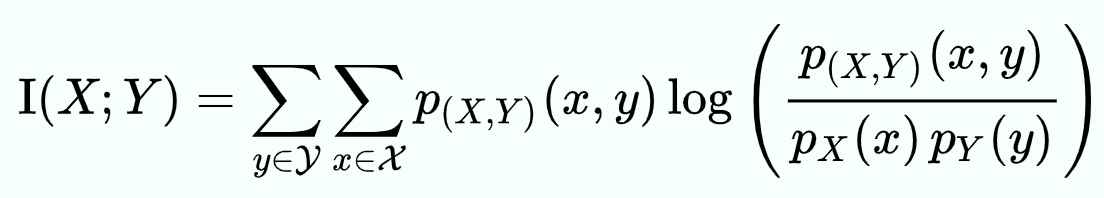

In [30]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [34]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[0]]
    p_y = marginal_y[xy[1]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [35]:
MI

0.4127510707411918

## Analytic fine-grained MI calculation
<a id='W6fWYl5TZGWfK9Zt8dXCH65nSc5Uk'></a>

In [38]:
X = np.array(Xlist).astype(float)#.reshape(-1, 9)
Y = np.array(Ylist).astype(float)#.reshape(-1, 9)

In [39]:
X

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [55]:
Xlist2x2 = []
Ylist2x2 = []
for _ in range(100000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 3)
    j = np.random.randint(dat.shape[1] - 6)

    Xlist2x2.append(dat[num, i:(i+2), j:(j+2)])
    Ylist2x2.append(dat[num, i:(i+2), (j+2):(j+4)])

X = np.array(Xlist2x2).astype(float).reshape(-1, 4)
Y = np.array(Ylist2x2).astype(float).reshape(-1, 4)

In [56]:
X

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 0.],
       ...,
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.]])

In [57]:
Y

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 0., 0.],
       ...,
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.]])

In [58]:
xy_pair = np.hstack([X, Y])

In [59]:
xy_pair[:3, :]

array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 1., 0., 0.]])

In [60]:
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[:4]] += 1
    marginal_y[tuple(pair)[4:]] += 1

In [61]:
joint_dict

defaultdict(int,
            {(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0): 888,
             (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 26138,
             (1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0): 227,
             (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 25517,
             (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0): 1670,
             (1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 1012,
             (1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0): 1006,
             (0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 540,
             (1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0): 1024,
             (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 513,
             (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0): 550,
             (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0): 941,
             (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0): 199,
             (0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0): 112,
             (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 1042,
             (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0): 115,
             (

In [62]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [63]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[:4]]
    p_y = marginal_y[xy[4:]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [64]:
MI

0.42191278953556094

In [65]:
Ylist2x2

[array([[0, 0],
        [0, 0]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [0, 0]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [1, 1]]), array([[1, 1],
        [1, 0]]), array([[1, 1],
        [1, 1]]), array([[1, 1],
        [1, 1]]), array([[1, 1],
        [1, 1]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [1, 1]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [1, 1]]), array([[0, 0],
        [0, 0]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [1, 1]]), array([[0, 1],
        [1, 1]]), array([[1, 1],
        [1, 0]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [1, 1]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [1, 1]]), array([[1, 1],
        [1, 1]]), array([[0, 0],
        [0, 0]]), array([[0, 0],
        [0, 0]]), array([[0, 0],
        [0, 0]]), array([[1, 1],
        [0, 0]]), array([[1, 1],
        [0, 1]]), array([[1, 1],
        [1, 1]]), array([[1, 1],
        [0, 1]]), array([[1

## Analytic MI frozen convolution
<a id='i4EUlSNUCLAqQFRTDCFVrpJ'></a>

In [66]:
X = 1/4 * (np.array(Xlist2x2).astype(float).sum(axis = (1, 2))  )
Y = 1/4 * (np.array(Ylist2x2).astype(float).sum(axis = (1, 2))  )

In [67]:
X

array([1.  , 0.  , 0.75, ..., 1.  , 0.  , 1.  ])

In [68]:
Y

array([0. , 0. , 0.5, ..., 1. , 0. , 1. ])

In [69]:
xy_pair = np.vstack([X, Y]).T
xy_pair

array([[1.  , 0.  ],
       [0.  , 0.  ],
       [0.75, 0.5 ],
       ...,
       [1.  , 1.  ],
       [0.  , 0.  ],
       [1.  , 1.  ]])

In [70]:
from collections import defaultdict
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[0]] += 1
    marginal_y[tuple(pair)[1]] += 1

In [71]:
joint_dict

defaultdict(int,
            {(1.0, 0.0): 888,
             (0.0, 0.0): 26138,
             (0.75, 0.5): 1156,
             (1.0, 1.0): 25517,
             (1.0, 0.75): 5289,
             (0.75, 1.0): 5352,
             (0.5, 1.0): 2333,
             (0.5, 0.0): 2525,
             (0.0, 0.5): 2566,
             (0.5, 0.75): 1227,
             (0.0, 0.25): 5465,
             (0.5, 0.25): 1204,
             (0.75, 0.75): 1685,
             (1.0, 0.5): 2442,
             (1.0, 0.25): 1061,
             (0.0, 0.75): 1071,
             (0.25, 0.0): 5439,
             (0.25, 0.25): 1730,
             (0.75, 0.0): 1036,
             (0.25, 1.0): 1030,
             (0.25, 0.5): 1227,
             (0.75, 0.25): 828,
             (0.25, 0.75): 793,
             (0.5, 0.5): 1178,
             (0.0, 1.0): 820})

In [72]:
marginal_x

defaultdict(int, {1.0: 35197, 0.0: 36060, 0.75: 10057, 0.5: 8467, 0.25: 10219})

In [73]:
marginal_y

defaultdict(int, {0.0: 36026, 0.5: 8569, 1.0: 35052, 0.75: 10065, 0.25: 10288})

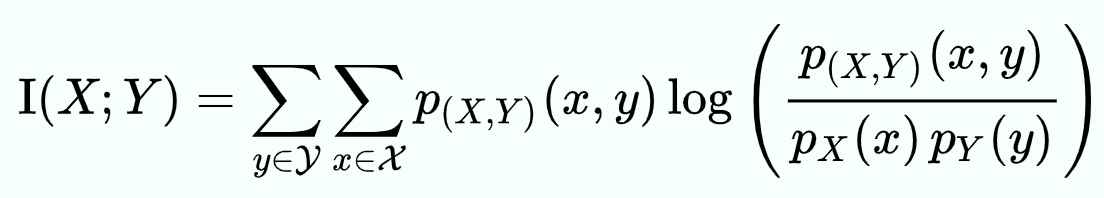

In [74]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [75]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[0]]
    p_y = marginal_y[xy[1]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [76]:
MI

0.37077272491123187

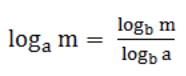

In [ ]:
log_2 x = log_e x / log_e 2
log_e (x() = log_2 (x) * log_e (2)


In [78]:
Fine_grained MI = 0.62  / np.log(2)

0.8944709253511574

In [ ]:
Fine_grained MI = 0.71

- Mine on the fine-grained data (on the 2x2 model)
- Mine on the frozen convolution coarse-graining (on the 2x2 model)
- Mine on the unfrozen convolution (and we optimize the convolution to get max info) (on the 2x2 model)
- Figure out if the log2 factor is confusing